In [1]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is sales price, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included codebook.txt file.

In [2]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [7]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [4]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [5]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [6]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [8]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

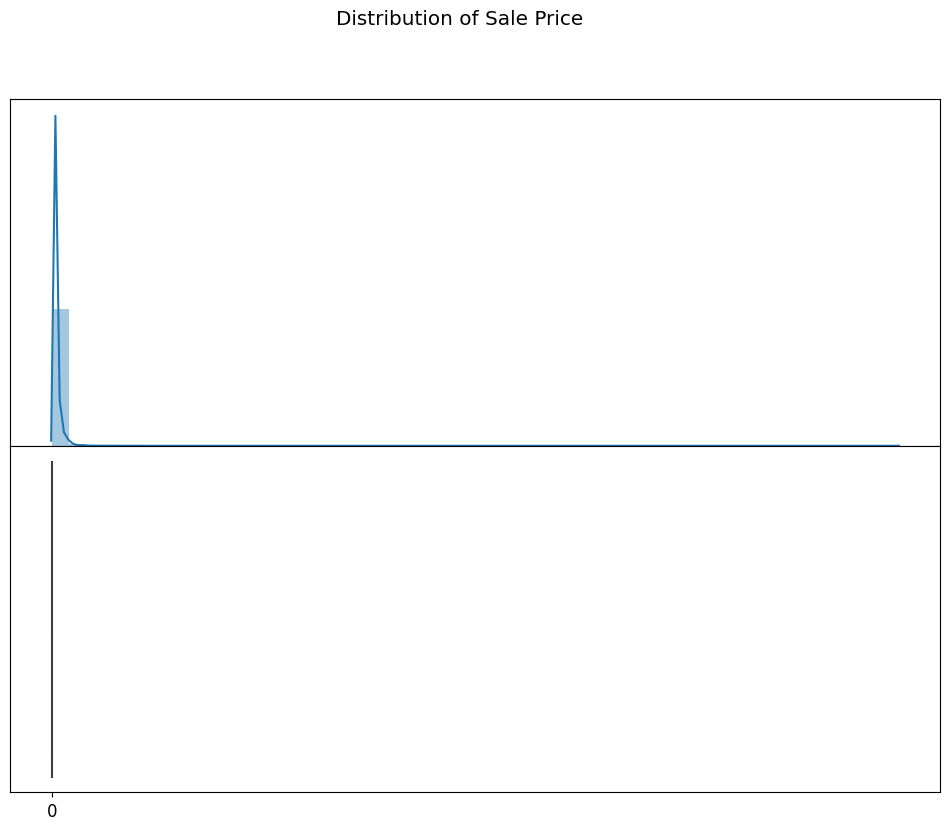

In [9]:
plot_distribution(training_data, label='Sale Price')

In [10]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

In [11]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

KeyError: 0

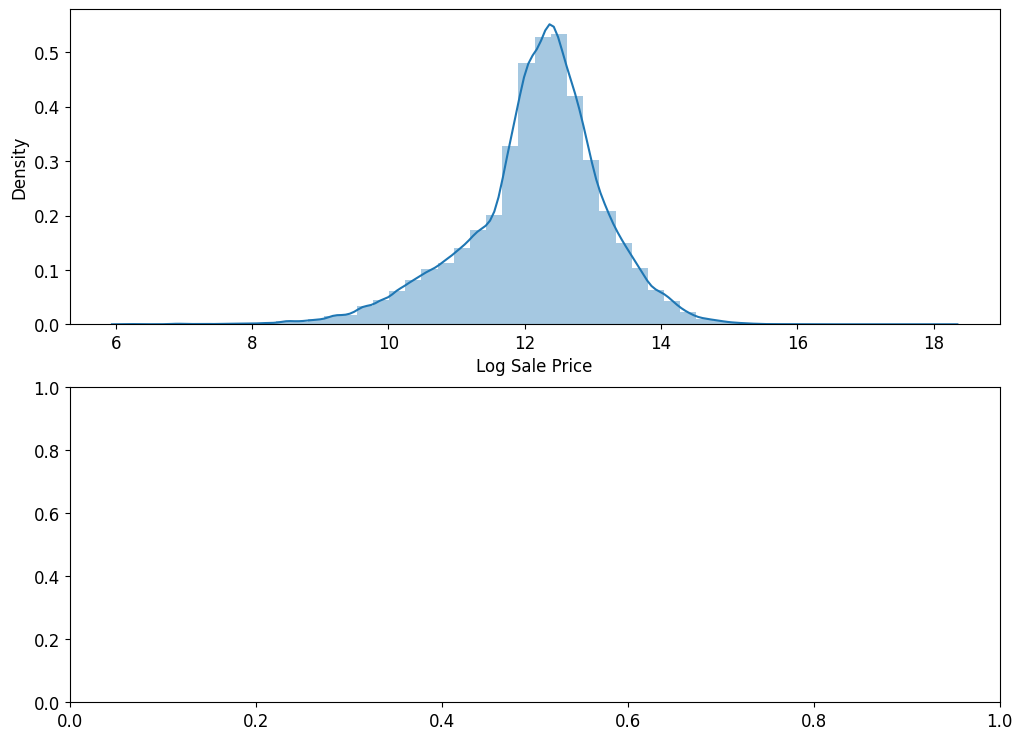

In [14]:
plot_distribution(training_data, label='Log Sale Price')

In [15]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

In [17]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] > lower) & (data[variable] <= upper)]

In [16]:
training_data['Description'][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [18]:
training_data['Description'].str.extract(r'\,\s(\d+)\s[^\,]+')

,0
1,3
2,3
3,3
4,2
6,4
...,...
204787,2
204788,4
204789,3
204790,3


In [19]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r'\,\s(\d+)\s[^\,]+')
    with_rooms['Bedrooms'] = pd.to_numeric(with_rooms['Bedrooms'])
    return with_rooms

training_data = add_total_bedrooms(training_data)

<Axes: xlabel='Bedrooms', ylabel='Log Sale Price'>

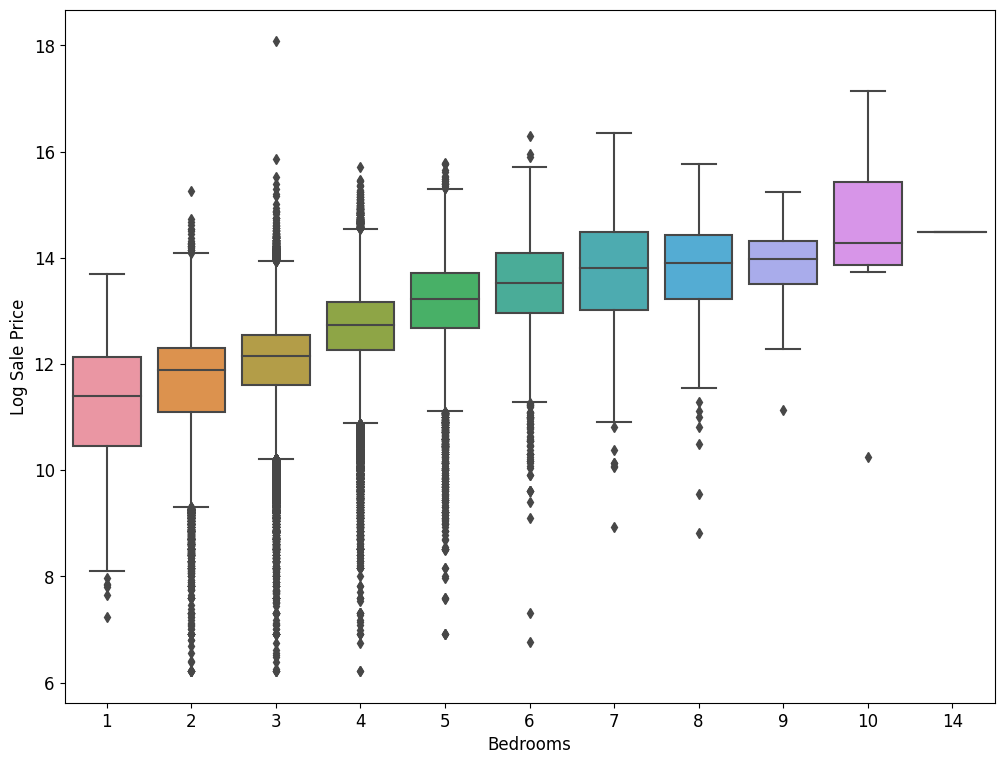

In [20]:
sns.boxplot(data = training_data, x = 'Bedrooms', y = 'Log Sale Price')

In [21]:
training_data['Neighborhood Code']

1         120
2         210
3         220
4         120
6         181
         ... 
204787    321
204788     21
204789     90
204790     80
204791     30
Name: Neighborhood Code, Length: 168931, dtype: int64

In [22]:
num_neighborhoods = len(training_data.groupby('Neighborhood Code'))
num_neighborhoods

193

In [23]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [24]:
top_20 = training_data['Neighborhood Code'].value_counts()[:20]
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20.index)]
in_top_20_neighborhoods

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2
8,13232040260000,205,70,3100.0,71,0.0,2.0,2.0,1.0,3.0,...,10.0,1,1.0,70,7170,"This property, sold on 08/25/2016, is a two-st...",3100.0,13.422468,7.636270,4
10,19074270080000,202,380,3750.0,72,0.0,1.0,1.0,2.0,3.0,...,7.4,1,1.0,380,72380,"This property, sold on 05/01/2017, is a one-st...",3750.0,11.695247,6.841615,2
11,15083050330000,203,20,5092.0,31,0.0,2.0,1.0,1.0,1.0,...,5.8,1,1.0,20,3120,"This property, sold on 04/29/2014, is a one-st...",5092.0,11.184421,6.911747,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204781,20361190390000,203,80,4405.0,70,0.0,2.0,1.0,1.0,3.0,...,5.7,1,1.0,80,7080,"This property, sold on 07/15/2013, is a one-st...",4405.0,10.913269,7.141245,3
204785,9284030280000,202,40,6650.0,22,0.0,1.0,1.0,1.0,3.0,...,6.1,1,1.0,40,2240,"This property, sold on 04/03/2014, is a one-st...",6650.0,11.736069,6.761573,3
204786,8141120110000,203,100,10010.0,16,0.0,2.0,1.0,1.0,1.0,...,5.6,1,1.0,100,16100,"This property, sold on 09/08/2016, is a one-st...",10010.0,12.568978,6.948897,3
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017,7.092574,3


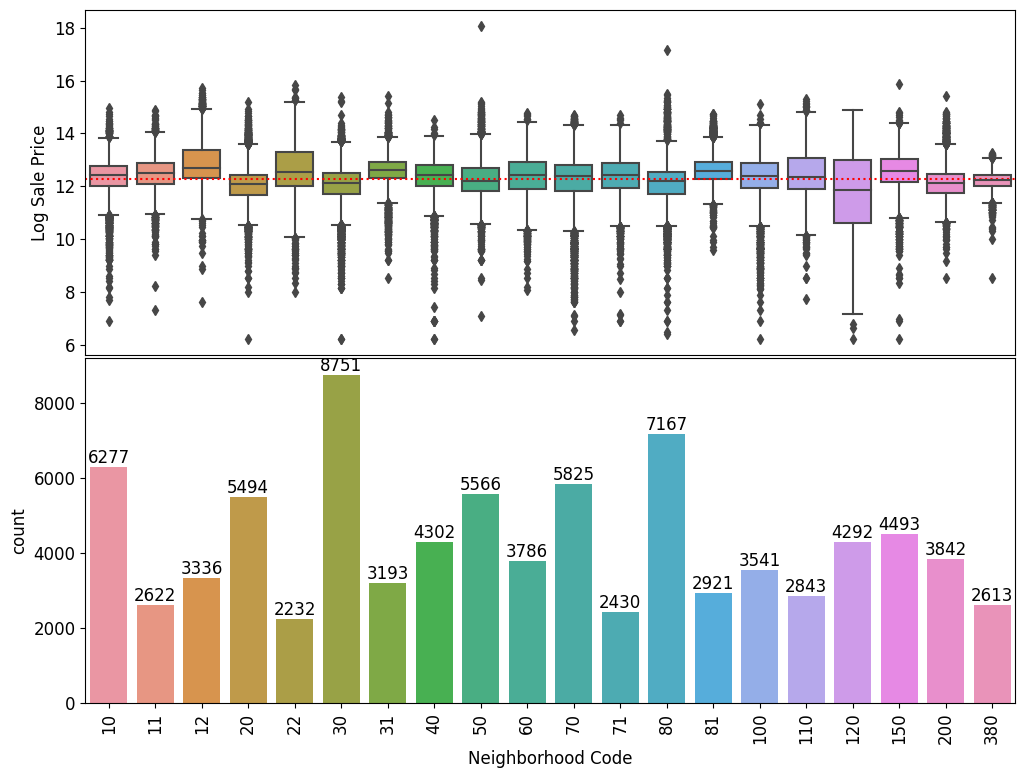

In [26]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

It doesn't look like there is a strong relationship between the house sale price and the neighborhood. Most of the plots look pretty similar. 

In [27]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = training_data[['Neighborhood Code', 'Log Sale Price']].groupby(['Neighborhood Code']).agg(metric).sort_values(by = 'Log Sale Price', ascending = False)[:n].index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [28]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column: 1 if in expensive neighborhood, 0 if not
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [29]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace({'Roof Material': {1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3:'Slate', 4:'Shake', 5:'Tile', 6:'Other'}})
    return data
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


In [ ]:
import sklearn

In [32]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    ohc = OneHotEncoder()
    ohc.fit(data[['Roof Material']])
    return data.join(pd.DataFrame(ohc.transform(data[['Roof Material']]).toarray(), columns = ohc.get_feature_names_out(), index=data.index))

    

training_data_ohe = ohe_roof_material(training_data)
# Return columns with name that starts with "Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


# Part 2

In [34]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [35]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In [36]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

# The CCAO Dataset
The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “racially discriminatory assessments and taxes." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, paid less in property taxes, whereas working-class, non-white homeowners paid more.

The Chicago Tribune's four-part series, "The Tax Divide", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation here.

In [37]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

np.random.seed(1337)

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    eighty_percent = int(data_len*0.8)
    train_indices = shuffled_indices[0:eighty_percent]
    validation_indices = shuffled_indices[eighty_percent:]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [92]:
def log_transform(dat, col = 'Sale Price'):
    """
    Input: 
        dat (DataFrame): a DataFrame
        col_name: a numeric column

    """
    new_col_name = "Log " + col
    with_log = dat.copy()
    dat[new_col_name] = np.log(dat[col])
    return dat

In [93]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r'\,\s(\d+)\s[^\,]+')
    with_rooms['Bedrooms'] = pd.to_numeric(with_rooms['Bedrooms'])
    return with_rooms


In [94]:
def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [95]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

In [96]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_gm(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [97]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_m2, y_train_m2 = process_data_gm(train_m1, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_gm(valid_m1, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(y_train_m1_simple.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870166
193890,2,7.002156
30507,2,6.851185
91308,2,7.228388
131132,3,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [61]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [98]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_valid_m1)


# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd /model
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

np.max(y_predicted_m2)

15.025639633057647

In [99]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [100]:
# Training and validation errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
validation_error_m1 = rmse(y_predicted_m1, y_valid_m1)

# Training and validation errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))
validation_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_valid_m1))


# Training and validation errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
validation_error_m2 = rmse(y_predicted_m2, y_valid_m2)


# Training and validation errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
validation_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_valid_m2))

print("1st Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1, validation_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1_delog, validation_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2, validation_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2_delog, validation_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699076
Validation RMSE: 0.9068644732045895

1st Model (no log transform)
Training RMSE: 382697.7814970115
Validation RMSE: 310679.24866115605

2nd Model
Training RMSE: 0.8042009333446841
Validation RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 325716.40819160384
Validation RMSE: 254880.42228506145



In [101]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ_0: {}\nθ_1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ_0: {}\nθ_1: {}\nθ_2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ_0: 10.571725401039847
θ_1: 0.49691974631421776
2nd Model
θ_0: 1.933963317382247
θ_1: -0.03064724980356704
θ_2: 1.4170991378689866


Theta 1 corresponds to the number of bedrooms, and we cans ee here that it changes from positive to negative. This means that the Log Building Square Feet has a much larger impact on price than the number of bedrooms.

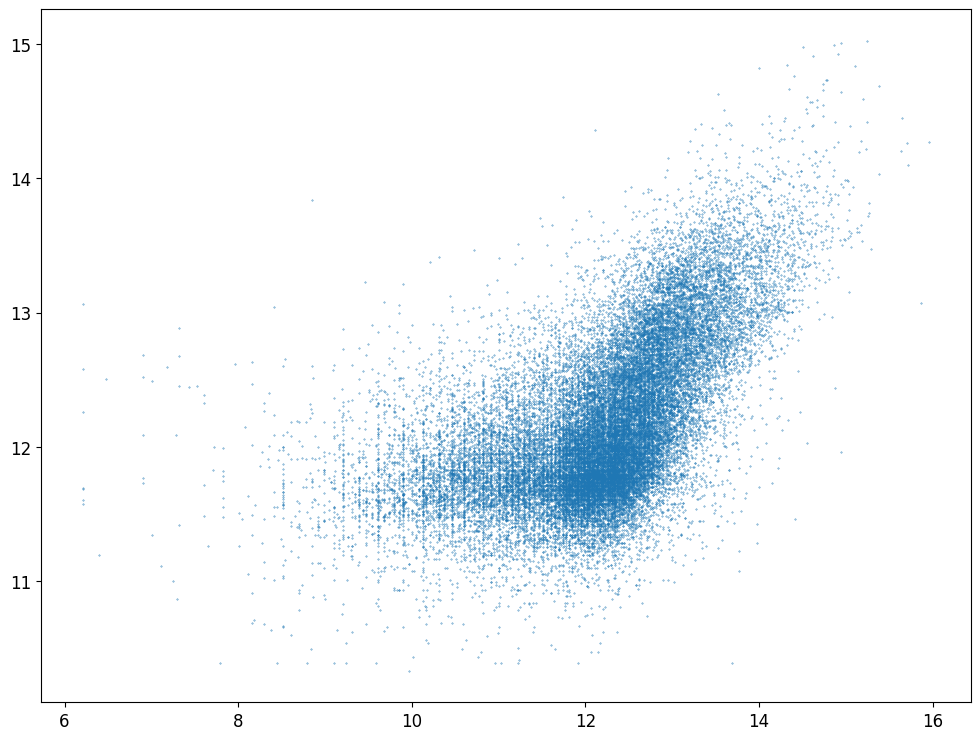

In [102]:
plt.scatter(y_valid_m2 , y_predicted_m2, alpha = 1, s = 1/10)

# Part 3
Building my own model. This next section is for Exploratory Data Analysis. In each cell I will be comparing the correlation of one feature to the Log Sale Price. If the correlation is high, I will use it in my final model at the end.

,Log Estimate (Land),Log Sale Price
Log Estimate (Land),1.00000,0.69387
Log Sale Price,0.69387,1.00000


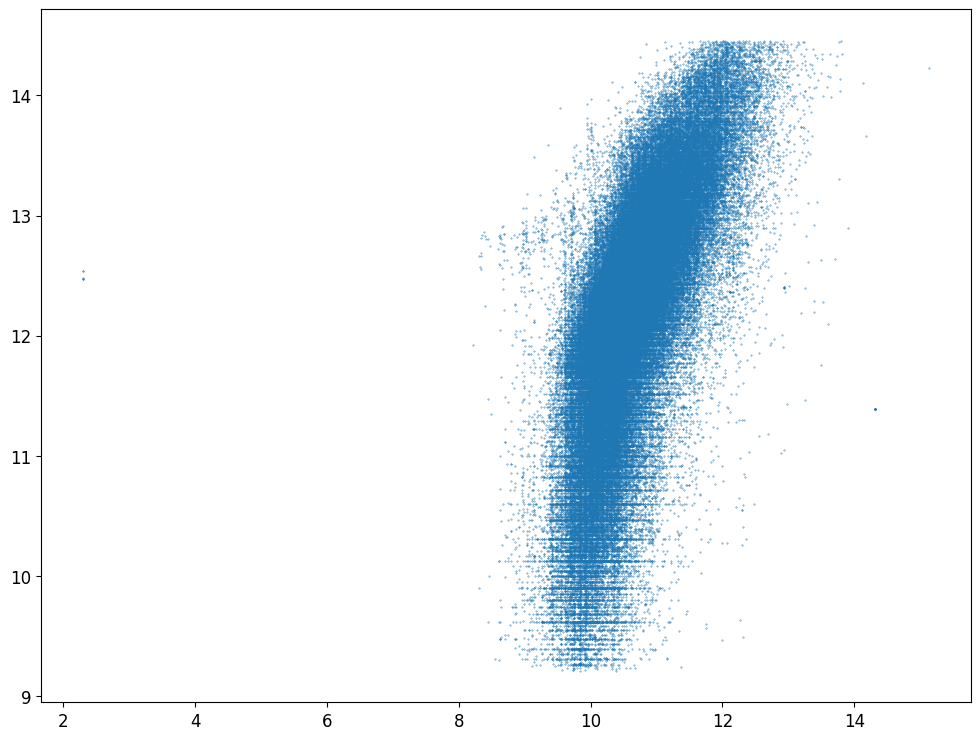

In [103]:
# Add any EDA code below
no_outliers = log_transform(training_val_data, 'Sale Price')['Log Sale Price']
no_outliers = log_transform(training_val_data, 'Estimate (Land)')['Log Estimate (Land)']

no_outliers = remove_outliers(training_val_data, variable = 'Sale Price', lower =  10000, upper = np.percentile(training_val_data['Sale Price'], 99.5))
10
plt.scatter(log_transform(no_outliers, 'Estimate (Land)')['Log Estimate (Land)'], 
            log_transform(no_outliers, 'Sale Price')['Log Sale Price'], s=1/10
           )

no_outliers[['Log Estimate (Land)', 'Log Sale Price']].corr()

In [105]:
no_outliers = remove_outliers(training_val_data, variable = 'Sale Price', lower =  10000, upper = np.percentile(training_val_data['Sale Price'], 99.5))
no_outliers['Garage 1 Size'].value_counts()

Garage 1 Size
3.0    94398
1.0    26324
0.0    19550
2.0    11701
4.0     7639
5.0     5791
7.0      514
6.0      450
Name: count, dtype: int64

,Log Estimate (Building),Log Sale Price
Log Estimate (Building),1.000000,0.790097
Log Sale Price,0.790097,1.000000


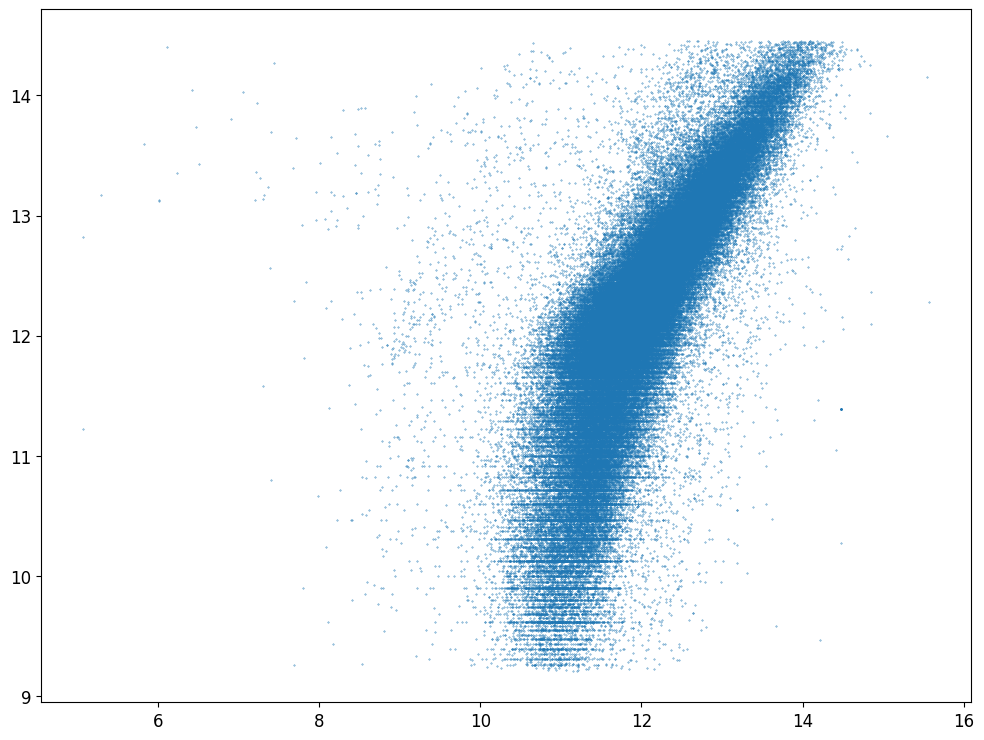

In [106]:
plt.scatter(log_transform(no_outliers, 'Estimate (Building)')['Log Estimate (Building)'], 
            log_transform(no_outliers, 'Sale Price')['Log Sale Price'], s=1/10
           )
no_outliers[['Log Estimate (Building)', 'Log Sale Price']].corr()

Garage 1 Size
3.0    94398
1.0    26324
0.0    19550
2.0    11701
4.0     7639
5.0     5791
7.0      514
6.0      450
Name: count, dtype: int64


<Axes: xlabel='Garage Indicator', ylabel='Log Sale Price'>

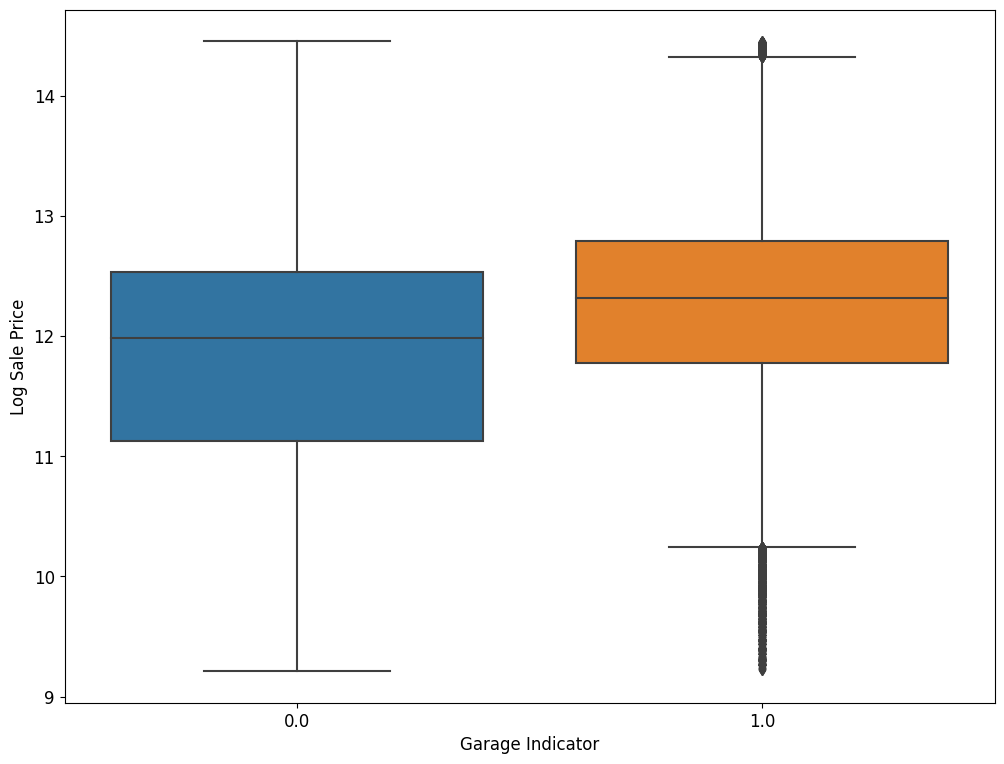

In [107]:
add_in_expensive_neighborhood(no_outliers, find_expensive_neighborhoods(no_outliers, n=3, metric=np.median))[['in_expensive_neighborhood', 'Log Sale Price']].groupby('in_expensive_neighborhood').agg(np.median)

no_outliers[['Garage Indicator', 'Log Sale Price']].groupby('Garage Indicator').agg(np.median)
print(no_outliers['Garage 1 Size'].value_counts())
no_outliers[['Garage 1 Size', 'Log Sale Price']].groupby('Garage 1 Size').agg(np.median)

sns.boxplot(x = 'Garage Indicator', y = 'Log Sale Price', data = no_outliers)


['Apartments' 'Building Square Feet' 'Estimate (Land)'
 'Estimate (Building)']


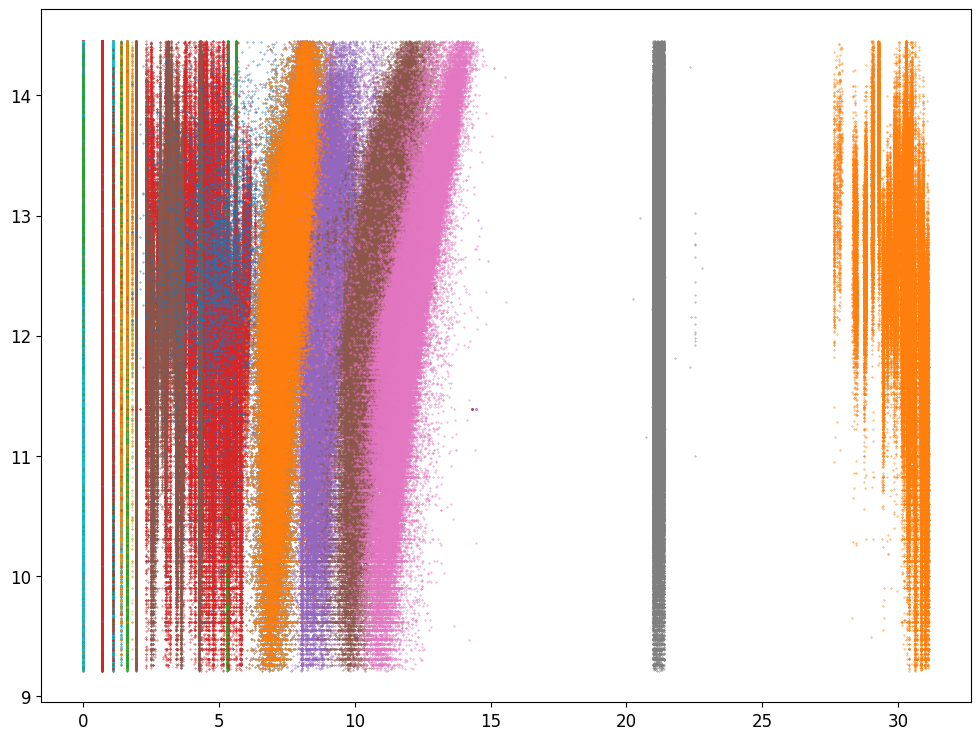

In [108]:
def calculate_corr_and_plot(guess):
    plt.scatter(log_transform(no_outliers, guess)['Log ' + guess], 
            log_transform(no_outliers, 'Sale Price')['Log Sale Price'], s=1/10
           )
    return (no_outliers[['Log ' + guess, 'Log Sale Price']].corr())['Log Sale Price'][0]
calculate_corr_and_plot('Building Square Feet')
no_outliers.columns


possible_features = np.array('init')
for feature in no_outliers.columns:
    cutoff = 0.5
    if feature == 'Sale Price':
        break
    
    if isinstance(no_outliers[feature][1], str):
        continue
        
    if calculate_corr_and_plot(feature) > cutoff:
        possible_features = np.append(possible_features, feature)
        
print(possible_features[1:])

In [110]:
find_expensive_neighborhoods(no_outliers, n = 20)

[44,
 94,
 93,
 106,
 580,
 67,
 117,
 143,
 166,
 96,
 64,
 400,
 48,
 461,
 132,
 83,
 74,
 95,
 116,
 84]

In [111]:
from sklearn.preprocessing import OneHotEncoder


def ohe_property_class(data):
    enc = OneHotEncoder()
    enc.fit(data[['Property Class']])
    data = data.join(pd.DataFrame(enc.transform(data[['Property Class']]).toarray(), columns = enc.get_feature_names_out(), index = data.index))
    data.drop(columns = ['Property Class'])
    return data, enc.get_feature_names_out()

def ohe_town_neighborhood(data):
    enc = OneHotEncoder()
    enc.fit(data[['Town and Neighborhood']])
    data = data.join(pd.DataFrame(enc.transform(data[['Town and Neighborhood']]).toarray(), columns = enc.get_feature_names_out(), index = data.index))
    data.drop(columns = ['Town and Neighborhood'])
    return data, enc.get_feature_names_out()

def add_all_rooms(data):
    data_copy = data.copy()
    data_copy['Rooms'] = data_copy['Description'].str.extract(r'has a total of (\d+) rooms').astype(int)
    return data_copy
    
def garage_1_class(data):
    enc = OneHotEncoder()
    enc.fit(data[['Garage 1 Size']])
    data = data.join(pd.DataFrame(enc.transform(data[['Garage 1 Size']]).toarray(), columns = enc.get_feature_names_out(), index=data.index))
    data.drop(columns = ['Garage 1 Size'])
    return data, enc.get_feature_names_out()

def central_air(data):
    enc = OneHotEncoder()
    enc.fit(data[['Central Air']])
    data = data.join(pd.DataFrame(enc.transform(data[['Central Air']]).toarray(), columns = enc.get_feature_names_out(), index=data.index))
    data.drop(columns = ['Central Air'])
    return data, enc.get_feature_names_out()

def fireplaces(data):
    enc = OneHotEncoder()
    enc.fit(data[['Fireplaces']])
    data = data.join(pd.DataFrame(enc.transform(data[['Fireplaces']]).toarray(), columns = enc.get_feature_names_out(), index=data.index))
    data.drop(columns = ['Fireplaces'])
    return data, enc.get_feature_names_out()

In [116]:
#From the ds100_utils package 
def run_linear_regression_test(
    final_model, 
    process_data_fm, 
    threshold, 
    train_data_path, 
    test_data_path, 
    is_test=False, 
    is_ranking=False,
    return_predictions=False
):
    def rmse(predicted, actual):
        return np.sqrt(np.mean((actual - predicted)**2))

    training_data = pd.read_csv(train_data_path, index_col='Unnamed: 0')
    X_train, y_train = process_data_fm(training_data)
    if is_test:
        test_data = pd.read_csv(test_data_path, index_col='Unnamed: 0')
        X_test = process_data_fm(test_data, is_test_set = True)
        assert len(test_data) == len(X_test), 'You may not remove data points from the test set!'

    final_model.fit(X_train, y_train)
    if is_test:
        return final_model.predict(X_test)
    else:
        y_predicted = final_model.predict(X_train)
        loss = rmse(np.exp(y_predicted), np.exp(y_train))
        if is_ranking:
            print('Your RMSE loss is: {}'.format(loss))
            return loss
        return loss < threshold
    
def run_linear_regression_test_optim(
    final_model, 
    process_data_fm, 
    train_data_path, 
    test_data_path, 
    is_test=False, 
    is_ranking=False,
    return_predictions=False
):
    def rmse(predicted, actual):
        return np.sqrt(np.mean((actual - predicted)**2))

    training_data = pd.read_csv(train_data_path, index_col='Unnamed: 0')
    X_train, y_train = process_data_fm(training_data)
    if is_test:
        test_data = pd.read_csv(test_data_path, index_col='Unnamed: 0')
        X_test = process_data_fm(test_data, is_test_set = True)
        assert len(test_data) == len(X_test), 'You may not remove data points from the test set!'

    final_model.fit(X_train, y_train)
    if is_test:
        return final_model.predict(X_test)
    else:
        y_predicted = final_model.predict(X_train)
        loss = rmse(np.exp(y_predicted), np.exp(y_train))
        if is_ranking:
            print('Your RMSE loss is: {}'.format(loss))
            return loss
        fn = (lambda threshold: loss < threshold)
        fn.loss = loss
        fn.signature = (process_data_fm, train_data_path, test_data_path)
        return fn

In [117]:
def process_data_fm(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        data=remove_outliers(data,variable='Sale Price',lower=np.percentile(data['Sale Price'],10),upper=np.percentile(data['Sale Price'],90))
        
        data = add_total_bedrooms(data) #'Bedrooms'
        
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'] )
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'].replace(to_replace = 0, value = np.median(data['Estimate (Building)'])))
        data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'].replace(to_replace = 0, value = np.median(data['Estimate (Land)'])))
        
        #ohe 
        data, property_class_columns = ohe_property_class(data)
        data, garage_1_class_labels = garage_1_class(data)
        data, central_air_labels = central_air(data)
        data, fireplace_labels = fireplaces(data)
        
        expensive_neighborhoods = [94, 44, 93, 106, 580, 67, 117, 143, 166, 96, 400, 64, 48, 461, 132, 83, 74, 95, 116, 18]
        data = add_in_expensive_neighborhood(data, expensive_neighborhoods)
        
        data = data[['Bedrooms', *property_class_columns, *garage_1_class_labels, *central_air_labels, *fireplace_labels, 'Log Building Square Feet', 'Log Estimate (Building)', 'Log Estimate (Land)', 'Log Sale Price']]
                

    else:
            

        # do your processing for the test set
        # this CANNOT involve references to sale price!
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'] )
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'].replace(to_replace = 0, value = np.median(data['Estimate (Building)'])))
        data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'].replace(to_replace = 0, value = np.median(data['Estimate (Land)'])))
        
        data = add_total_bedrooms(data)
        
        data, property_class_columns = ohe_property_class(data)
        data, garage_1_class_labels = garage_1_class(data)
        data, central_air_labels = central_air(data)
        data, fireplace_labels = fireplaces(data)
        
        expensive_neighborhoods = [94, 44, 93, 106, 580, 67, 117, 143, 166, 96, 400, 64, 48, 461, 132, 83, 74, 95, 116, 18]
        data = add_in_expensive_neighborhood(data, expensive_neighborhoods)
        
        data = data[['Bedrooms', *property_class_columns, *garage_1_class_labels, *central_air_labels, *fireplace_labels, 'Log Building Square Feet', 'Log Estimate (Building)', 'Log Estimate (Land)']]
                
    
    # do your processing for the both train and test set
    
    
    
    # Return predictors and response variable separately
    if is_test_set:
        # Optional processing you wish to do, remove ellipsis before submission
        
        # Predictors
        X = data
        return X
    else:
        # Optional processing you wish to do, remove ellipsis before submission
        
        # Predictors. Your X should not include Log Sale Price!
        X = data.loc[:, data.columns != 'Log Sale Price']
        # Response variable
        y = data['Log Sale Price']
        
        return X, y

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 125062.20382479997


In [192]:
training_data = pd.read_csv('cook_county_train.csv')
X_train, y_train = process_data_fm(training_data)

val_set = pd.read_csv('cook_county_train_val.csv')
X_val, y_val = process_data_fm(val_set)

test_set = pd.read_csv('cook_county_contest_test.csv')
X_test = process_data_fm(test_set, is_test_set = True)

In [140]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [165]:
reg.coef_

array([-1.56251123e-02, -7.72029101e+09, -7.72029101e+09, -7.72029101e+09,
       -7.72029101e+09, -7.72029101e+09, -7.72029101e+09, -7.72029101e+09,
       -7.72029101e+09, -7.72029101e+09, -4.44770238e+09, -4.44770238e+09,
       -4.44770238e+09, -4.44770238e+09, -4.44770238e+09, -4.44770238e+09,
       -4.44770238e+09, -4.44770238e+09, -1.93378579e+10, -1.93378579e+10,
       -2.16191975e+10, -2.16191975e+10, -2.16191975e+10,  1.09798431e-01,
        8.06118965e-01,  4.42742348e-01])

In [145]:
rmse(reg.predict(X_train), y_train)

0.6634135962865326

In [211]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE

In [212]:
n_folds = 10
kf = KFold(n_splits=n_folds)

In [215]:
lm = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, scoring='r2', cv=10)
scores

array([0.49370892, 0.49129069, 0.49757222, 0.50234233, 0.50934681,
       0.49146333, 0.50073131, 0.4618449 , 0.51826391, 0.52841378])

In [214]:
scores = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
scores

array([-0.66657339, -0.677662  , -0.66742721, -0.65110123, -0.64633159,
       -0.67015423, -0.65295055, -0.70544278, -0.65149995, -0.64425015])

In [216]:
folds = KFold(n_splits = 10, shuffle = True)
scores = cross_val_score(lm, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
scores  

array([-0.6741093 , -0.66200054, -0.68980749, -0.68017356, -0.64974312,
       -0.6641538 , -0.66239267, -0.65466817, -0.64647656, -0.65080072])

In [217]:
len(X_train.columns)

26

In [221]:
# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 27))}]


# step-3: perform grid search
# 3.1 specify model
lreg = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lreg)          

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 26 candidates, totalling 260 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26]}],
             return_train_score=True, scoring='r2', verbose=1)

In [219]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.489058,0.144718,0.004902,0.001220,1,{'n_features_to_select': 1},0.066268,0.074736,0.081172,0.080651,...,0.075892,0.080006,0.068296,0.008385,0.000344,0.008497,0.077126,0.077107,0.053299,0.031440
1,1.476846,0.148352,0.004103,0.000702,2,{'n_features_to_select': 2},0.109735,0.119737,0.081210,0.081075,...,0.075886,0.080602,0.114387,0.080072,0.003003,0.080744,0.077119,0.077101,0.081757,0.030777
2,1.536620,0.215928,0.004598,0.000803,3,{'n_features_to_select': 3},0.124117,0.134039,0.126299,0.081071,...,0.120029,0.080597,0.127456,0.080067,0.059198,0.080744,0.082612,0.082551,0.096768,0.024390
3,1.307095,0.023571,0.003808,0.000409,4,{'n_features_to_select': 4},0.128553,0.138780,0.126922,0.100569,...,0.120537,0.099016,0.131743,0.098499,0.064736,0.080887,0.082937,0.082849,0.102412,0.023555
4,1.276709,0.019872,0.004002,0.000776,5,{'n_features_to_select': 5},0.129621,0.140302,0.126926,0.100677,...,0.120535,0.099154,0.133532,0.098636,0.085053,0.083930,0.083085,0.082984,0.105369,0.021326
5,1.258030,0.022309,0.004322,0.000801,6,{'n_features_to_select': 6},0.131004,0.140536,0.135906,0.101651,...,0.130160,0.100049,0.134263,0.099563,0.093395,0.084090,0.092709,0.092769,0.109504,0.019743
6,1.244189,0.025897,0.004078,0.000493,7,{'n_features_to_select': 7},0.131125,0.140298,0.137620,0.103417,...,0.131678,0.103053,0.134312,0.102480,0.101528,0.096843,0.093814,0.093908,0.112578,0.017394
7,1.233887,0.029265,0.004002,0.000008,8,{'n_features_to_select': 8},0.131126,0.140280,0.139241,0.113228,...,0.132794,0.112153,0.134312,0.111873,0.135700,0.098792,0.098170,0.097949,0.118991,0.015944
8,1.197019,0.018924,0.004501,0.000499,9,{'n_features_to_select': 9},0.131124,0.140221,0.139015,0.119254,...,0.132999,0.117066,0.134287,0.116893,0.135684,0.101579,0.099731,0.099424,0.120578,0.014844
9,1.158917,0.015112,0.004178,0.000417,10,{'n_features_to_select': 10},0.134005,0.157323,0.140337,0.124781,...,0.134080,0.122412,0.150194,0.122212,0.151673,0.103500,0.099734,0.099426,0.126957,0.019735


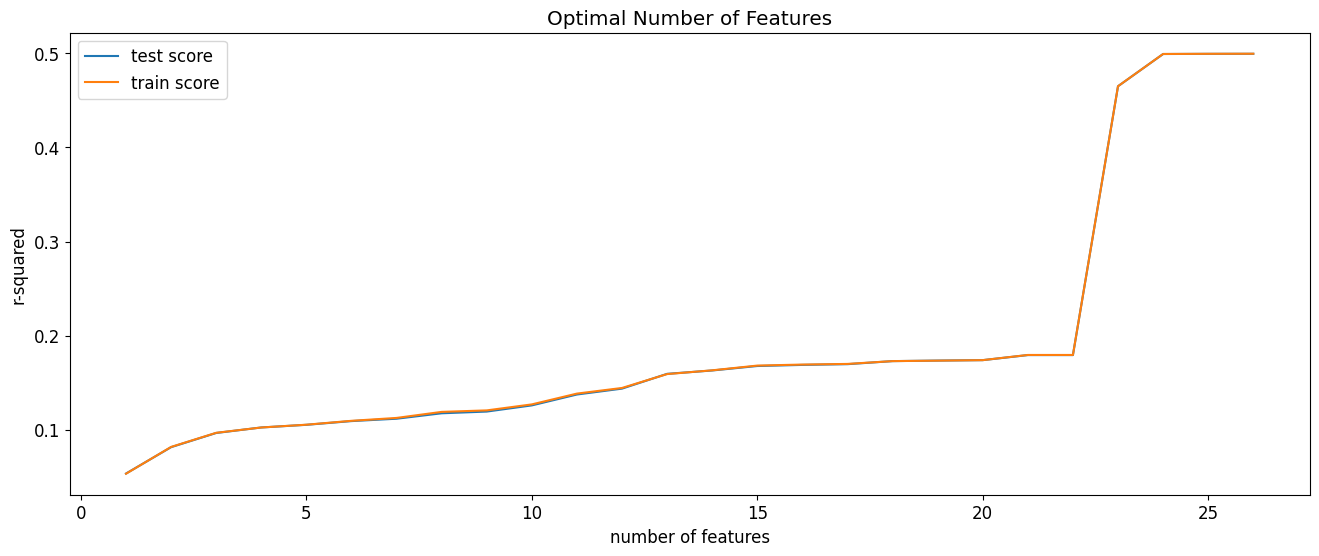

In [220]:
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')